In [85]:
from util_nn import *

import matplotlib 
import matplotlib.pyplot as plt
#%matplotlib inline
import IPython.display as ipd
import copy
import util_midi
import mir_eval
from util_midi import *
%matplotlib inline

def rmsq(X):
    return np.sqrt((X**2).mean())
def norm_by_freq(mroll):
    #### This may be improved
    wt = (np.linspace(0,1,mroll.shape[1])).T
#         sqwt = wt**2
#         sq_mroll = mroll **2
#         SUM = (sq_mroll*sqwt).sum(axis = 1,keepdims = 1)
    mroll = mroll*wt
    SUM = mroll.sum(axis = 1,keepdims = 1)
#         SUM = (mroll*wt).sum(axis = 1,keepdims = 1)
    SUM[SUM==0]=1
    mroll = mroll/SUM.astype('float32')
    return mroll

def mroll2chroma(mroll,norm = 1):
#     if chroma:
    if mroll.shape[-1]==12:
        return mroll
    mroll = mroll[:,:120]
    SP = list(mroll.shape)
#         SP[1] = 12; SP.append(-1)
#         mroll = np.reshape(mroll,SP).sum(axis = 2)
    SP[1] = -1; SP.append(12)
#     cmroll = np.clip(cmroll,0,1)
    #     cmroll = 
    if norm:
        mroll = norm_by_freq(mroll)
        

#         SUM = cmroll.sum(axis = 1,keepdims =1 )
#         SUM[SUM==0]=1
#         cmroll = cmroll / SUM.astype(float)
#     cmroll = (np.reshape(mroll,SP).sum(axis = 1) > 0).astype('float')
    cmroll = (np.reshape(mroll,SP).sum(axis = 1)).astype('float')
#         cmroll = np.clip(cmroll,0,1)
    return cmroll 
#     print mroll.shape

    
def midi_roll_play(mroll,chroma = False):
    if mroll.shape[-1]==12:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(60,72))
    else:
        freqs = mir_eval.transcription.util.midi_to_hz(np.arange(0,128))
#     mroll = np.log(mroll+1E-5)
    SHAPE = mroll.shape
    mroll = mroll.T
#     mroll = mroll * freqs.T[:,None]
#     mroll = norm_by_freq(mroll)
    Xs_exp = mir_eval.sonify.time_frequency( mroll ,freqs,times = 1./20*np.arange(SHAPE[0]),fs = 16000)
#     Xs_exp = np.hstack([Xs_exp,[0]*(len(cpXs)-len(Xs_exp))])
    return Xs_exp/np.sqrt((Xs_exp**2).mean())


def compare(log = 1, mode = 'test',best_agent = None,chroma = False,overlap = 1):
    FSIZE = [12,4]
    if best_agent is None:
        best_agent = copy.copy(agent)
        best_agent.load()
    plt.figure(figsize = FSIZE)

    if mode == 'test':
        pXs = data[0]["X"][:100]
        pYs_exp = data[0]["Y"][:100]
    else:
        pXs = Xs[:100]
        pYs_exp = Ys[:100]
#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = best_agent.model.predict_on_batch(pXs) 
    pYs_act += 1E-5
#     compare(log = 1)
    if chroma:
        if pYs_exp.shape[-1]==128:
            pYs_exp = mroll2chroma(pYs_exp,norm = 1)
        if pYs_act.shape[-1]==128:
            pYs_act = mroll2chroma(pYs_act,norm = 1)
    plt.pcolormesh(pYs_exp.T,alpha = 0.75)
    if overlap:
        pass
    else:
        plt.figure(figsize = FSIZE)
        
    Z1 = pYs_act.T
    if log:
        plt.pcolormesh(Z1,
                       alpha = 0.5,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    else:
        plt.pcolormesh(Z1)
#     if overlap:
#         pass
#     else:
    if 1:
        plt.figure(figsize = FSIZE)
    plt.pcolormesh((pYs_act - pYs_exp).T )
        
    if chroma:
        YLIM = [0,12]
    else:
        YLIM = [40,90]
    plt.gca().set_ylim(YLIM)
#     plt.gca().set_xlim(0,200)
#     plt.gca().set_ylim(YLIM)
#     plt.figure()
    
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    ipd.display(ipd.Audio(midi_roll_play(pYs_exp),rate = 16000))
    cpXs = np.concatenate(pXs,axis = 0)
    ipd.display(ipd.Audio(cpXs,rate = 16000))

    
# ali = 'test'
# alias = 't4'
def pretrain(agent = None, batchsize = 30000,nepc = 10,bsize=  512):
    IniEPOCH=0
    if agent is None:
        agent = PGAgent(16000/20, 128,model = make_model())

    # data = load_data()
    # Xs,Ys = make_buffer(data[1:])
    if batchsize== -1:
        batchsize = len(Xs)
    idx = np.random.choice(len(Xs),batchsize,replace=0)
    subXs = Xs[idx]
    subYs = Ys[idx]

#     opt_par.update({'loss':LOSS})
    try:
    #     agent.load()
        pass
    except Exception as e:
        print e
    # opt_par = {}
    # opt = keras.optimizers.Adam(**opt_par)
    # agent.name = "adam_%s"%opt_par_flat

    opt_par_flat = '-'.join(['_'.join(str(y) for y in x) for x in opt_par.items()]).replace('.','Dot')
    agent.name = "sgd_%s_%s"% (alias,flatten_param(opt_par))



    agent.model.compile(loss=LOSS, optimizer=opt
                         ,metrics=['accuracy'])

#     nepc = 10
    r = agent.model.fit(subXs, subYs, epochs= IniEPOCH + nepc, initial_epoch=IniEPOCH, batch_size=bsize , validation_split=0.2,shuffle = 1, verbose = 1,
                         callbacks=default_callbacks(agent))
    IniEPOCH += nepc
    plot_model_loss(r)
    return agent,r
# agent = pretrain()
# compare(log = 1, mode = 'test',chroma = 1)
# compare(log = 1, mode = 'test',chroma = 0)

# pXs = data[0]["X"][:100]
# pYs_exp = data[0]["Y"][:100]
# ipd.display(ipd.Audio(midi_roll_play(pYs_exp,chroma = 1),rate = 16000))

import sys
# class ClearlineCallback(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         sys.stdout.write("\033[F")
#         sys.stdout.write("\033[F")
#         print "\r\r"
class NewlineCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print
    def on_epoch_end(self, epoch, logs={}):
        print
        pass
#         print "\n"
import keras


def default_callbacks(self):
    ck_all = self.callback_checkpoint(0)
    ck_best = self.callback_checkpoint(1)
    callbacks = [
#         ClearlineCallback(),
#         keras.callbacks.ProgbarLogger(),
                 NewlineCallback(),
                 ck_all,
                 ck_best,
#                  NewlineCallback()
                ]
    return callbacks

# def abs_KL_div(y_true, y_pred):
#     y_true = K.clip(y_true, K.epsilon(), 1)
#     y_pred = K.clip(y_pred, K.epsilon(), 1)
#     return K.sum(y_true * K.abs(K.log(y_true / y_pred)), axis=-1)

In [150]:
# LOSS = 'kullback_leibler_divergence'
# LOSS = 'mean_absolute_percentage_error'
# LOSS = 'mean_absolute_error'
# LOSS = 'mean_squared_error'
# LOSS = 'hinge'
# LOSS = 'categorical_crossentropy'
# LOSS = 'mean_per'
# LOSS = 'binary_crossentropy'
alias = 't25'
# ACT_FUNC = "selu"
ACT_FUNC = "relu"
# tf.device('/cpu:0')
# LOSS = 'sparse_categorical_crossentropy'
# LOSS = 'binary_crossentropy'
from keras.models import Model


# Ns = [2,2,3,4,5,6][::-1]
# Ns = [2,2,2,2,2,2][::-1]
# Ss = [2,2,2,2,2,2][::-1]
# Ns = [3,3,3][::-1]
# Ss = [3,3,3][::-1]

Ns = [2,3,4,5,6][::-1]
Ss = [1,2,2,3,4][::-1]
LOSS = abs_KL_div


def make_model(self = None):
    
    model = Sequential()
#         model = Sequential_wrapper()
#         model.add(Reshape((80, 80, 1), input_shape=(self.state_size,)))
    
#     model.add(Reshape((self.state_size,1), input_shape=(self.state_size,)))
    input_size = 800; output_size = 128
    model.add(Reshape((input_size,1,1), input_shape=(input_size,)))

#     S = 85;niter = 1
    S = 9;niter = 2
#     S = 4;niter = 3    
    niter = 4
    n = S
    nextlayer = lambda x:(    x//n - 1)
    
    N0 = 64
    S2 = 30
    N2 = 10
    Lx = 800
    
#         if i == 0:

#     #         N = 1 if i==0 else N0
#             N = N0
#             if i==0:
#                 N2_curr = 1
#             else:
#                 N2_curr = N2
    N2_curr = 1
    N = 10
#     model.add(Conv2D( N, ( int(1.5*S),   N2_curr), strides=(S, N2_curr),
#     #                          subsample=(1, 1), 
#     #                          border_mode='same',
#                      border_mode='valid',
#                             activation=ACT_FUNC, init='he_uniform'))
#     model. add(Flatten())
#             model.add( Permute( (1,3,2,) ) )
#             Lx = nextlayer(Lx)

            
#             model.add(Conv2D( N, (1, N,), strides=(1,N),
#                              border_mode='valid',
#                                     activation=ACT_FUNC, init='he_uniform'))
#             model.add( Permute( (1,3,2,) ) )
#         else:
#             model.add(Conv2D( 16, ( int(1.5*S),   int(1.5 * S2)), strides=(S, S2),
#             #                          subsample=(1, 1), 
#             #                          border_mode='same',
#                              border_mode='valid',
#                                     activation=ACT_FUNC, init='he_uniform'))
#             N = 16
#             model.add( Permute( (1,3,2,) ) )
#             model.add(Conv2D( N, (1, N,), strides=(1,N),
#                              border_mode='valid',
#                                     activation=ACT_FUNC, init='he_uniform'))
#             model.add( Permute( (1,3,2,) ) )
#             pass
#     Ns = [128,64,32,64,128]
#     Ns = [128,128,100,64,64,64,100,128]
    def conv_dense(model,N,S, reshape = 1):
        model.add(Conv2D( N, ( S*2, 1), strides=(S, 1),
    #             #                          subsample=(1, 1), 
    #             #                          border_mode='same',
                                 border_mode='valid',
                                        activation=ACT_FUNC, init='he_uniform'))
        model.add(Dense(N,activation=ACT_FUNC,
#                              kernel_regularizer=keras.regularizers.l2(0.1),
#                             activity_regularizer=keras.regularizers.l1(0.01)
               )
         )
        
        
#     from keras.layers import Input, Embedding, LSTM, Dense
#     from keras.models import Model

    # Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
    # Note that we can name any layer by passing it a "name" argument.
    main_input = Input(shape=(800,), 
#                        dtype='int32', name='main_input'
                      )
    curr = Reshape((input_size,1,1), input_shape=(input_size,))(main_input)
    # This embedding layer will encode the input sequence
    # into a sequence of dense 512-dimensional vectors.
#     x = Embedding(output_dim=512, input_dim=10000, input_length=100)(main_input)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    S = 16
    N = 16
    niter = 1
    rNS = 0.5

    def conv_layer(curr,S,rNS=0.5):
#         S = 8
#         N = int(S/rNS)
        N = 16
#         N = S // rNS
        conv0 = Conv2D( N, ( S*2, 1),
                       strides=(S, 1),
#                                      border_mode='valid',
                                     border_mode='same',
                                            activation=ACT_FUNC, init='he_uniform')(curr)
        if SC == 1:
            ### A
            conv0 = Reshape((-1,25,N))(conv0)
            return conv0
        elif SC == 2:
            ### B
            conv0 = Reshape((25,-1,N))(conv0)
            return conv0

    
#     for S in 2**np.arange(3,6):
    N = 5
    S = 5
#     Ns = [3,4,5,6]
#     Ss = [3,4,5,6]
#     Ns = [2,2,6,6,6][::-1]
#     Ss = [1,1,3,5,6][::-1]
#     Ns = [3,4,5,6][::-1]
#     Ss = [3,4,5,6][::-1]
#     Ns = [1,4,5,6][::-1]
#     Ss = [3,4,5,6][::-1]
#     Ns = [3,7,9,12][::-1]
#     Ns = [5,7,8,9][::-1]
#     Ss = [2,3,3,3][::-1]
#     Ns = [6,6,6][::-1]
#     Ss = [3,3,3][::-1]
#     Ns = [2,3,4,5][::-1]
#     Ss = [1,2,3,4][::-1]
#     Ns = [5,7,8,9][::-1]
#     Ns = [2,3,4,5][::-1]

#     Ss = [3,4,4,4][::-1]
#     Ns = [2,6,8,10][::-1]
#     Ss = [3,4,5,6][::-1]
#     Ss = [2,3,4,5][::-1]
#     Ns = [12,12,2,2]
#     Ss = [1,1,16,16]
#     imax = 4
    imax = len(Ns)
    for i in range(imax):
#     for i in range(int(np.log(800)/np.log(S))-1):
        N = Ns[i];S = Ss[i]
        curr = Conv2D( N, ( S*4, 1),
               strides=(S, 1),
                                     border_mode='valid',
#                              border_mode='same',
                                    activation=ACT_FUNC, init='he_uniform')(curr)
#           print curr.get_shape()[1]
#         curr = Reshape((int(curr.get_shape()[1]),-1,1))(curr)
        curr = Reshape((int(curr.get_shape()[1]),1,-1))(curr)
#         curr = Dense(int(curr.get_shape()[-1]))(curr)
        if i+1==imax:
#             curr = Dense(12)(curr)
            pass
        curr = Permute((1,3,2))(curr)
#         conv=conv_layer(curr,(800//S + 800//(S+1))//2)
#         conv=conv_layer(curr,S)
#         clayer.append(
    concat = Flatten()(curr)
#     concat = curr
#     main_output = Dense(128,activation='softmax')(Flatten()(concat))
#     main_output = Dense(12,activation='softmax')(Flatten()(concat))

#     out1 = Dense(128,activation='sigmoid')(concat)
    out1 = Dense(128,activation='softmax')(concat)
#     out2 = Dense(128,activation='softmax')(curr)
    out2 = None
#     out3 = Dense(128,activation='softmax')(curr)
    out3 = None
    total= keras.layers.Lambda(lambda x: keras.backend.clip(x,0.01,None))(
        Dense(1,activation='relu')(concat))
# BatchNormalization    
    Llst = [(out) for out in [out1,out2,out3] if out is not None]
#     Llst = [BatchNormalization(axis=1)(out) for out in [out1,out2,out3] if out is not None]
    if len(Llst) > 1: 
        main_output = keras.layers.add(Llst)
    else:
        main_output = Llst[0]
    main_output = keras.layers.multiply([main_output,total])
#     main_output = Dense(128,activation='sigmoid')(Flatten()(concat))
#     main_output = Dense(12,activation='linear')(Flatten()(concat))
#     main_output = Dense(128,activation='softmax')(Flatten()(concat))
    model = Model(inputs=[main_input], outputs=[main_output])

    opt = Adam()
    model.compile(loss=LOSS, optimizer=opt
                 ,metrics=['accuracy'])
    return model
# model.add(Dense(100, activation='relu'))
# make_model()

agent = PGAgent(16000/20, 128,model = make_model())
# agent.load()
agent.summary()
IniEPOCH = 0

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 800)          0                                            
__________________________________________________________________________________________________
reshape_126 (Reshape)           (None, 800, 1, 1)    0           input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 197, 1, 6)    102         reshape_126[0][0]                
__________________________________________________________________________________________________
reshape_127 (Reshape)           (None, 197, 1, 6)    0           conv2d_89[0][0]                  
__________________________________________________________________________________________________
permute_89

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (16, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (12, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/pyt

In [67]:
# fname = 'Models/sgd_t23_lr_0Dot01-momentum_0Dot05-decay_0Dot0-05-0.46.hdf5'
fname = 'Models/archive/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-05-0.25.hdf5'
old_model = keras.models.load_model(fname,custom_objects=cObj)

In [151]:
# m.summary()
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
# m = make_model()
m = agent.model
for d,L in enumerate(m.layers):
# for d,L in m.layers_by_depth.iteritems():
    print d,L
    if d==19:
        break
    w  = old_model.layers[d].get_weights() 
    if w:
        L.set_weights( w)
agent.model = m
        

0 <keras.engine.topology.InputLayer object at 0x7f2387011f50>
1 <keras.layers.core.Reshape object at 0x7f2387011bd0>
2 <keras.layers.convolutional.Conv2D object at 0x7f2387011350>
3 <keras.layers.core.Reshape object at 0x7f23826dde10>
4 <keras.layers.core.Permute object at 0x7f23826dda50>
5 <keras.layers.convolutional.Conv2D object at 0x7f2386fe93d0>
6 <keras.layers.core.Reshape object at 0x7f2386fe9450>
7 <keras.layers.core.Permute object at 0x7f238716bad0>
8 <keras.layers.convolutional.Conv2D object at 0x7f2386ff3890>
9 <keras.layers.core.Reshape object at 0x7f2386ff3390>
10 <keras.layers.core.Permute object at 0x7f2386ffdc50>
11 <keras.layers.convolutional.Conv2D object at 0x7f2386fbd810>
12 <keras.layers.core.Reshape object at 0x7f2386fbd710>
13 <keras.layers.core.Permute object at 0x7f238707a510>
14 <keras.layers.convolutional.Conv2D object at 0x7f2387154d50>
15 <keras.layers.core.Reshape object at 0x7f23870d3610>
16 <keras.layers.core.Permute object at 0x7f238715fd90>
17 <keras.l

ValueError: Layer weight shape (5760, 1) not compatible with provided weight shape (5760, 128)

In [152]:
agent = PGAgent(800,128,model = m)
# m.save_weights('temp.w')

In [160]:
!find Models -type f -name '*.hdf5' -mtime +2 -delete

In [9]:
!ls Models/sgd_{alias}* -tl

-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:45 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.40.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:45 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.40.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:44 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.31.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647784 Dec 12 12:44 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.30.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647816 Dec 12 12:00 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.37.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647816 Dec 12 10:57 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.37.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647816 Dec 12 10:55 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.36.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647776 Dec 12 10:18 Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-10-0.37.hdf5
-rw-rw-r-- 1 shouldsee shouldsee  647776

In [161]:
# !mkdir -p Models/archive
fname = !ls Models/sgd_{alias}* -t | head -1
!cp {fname[0]} Models/archive
!ls Models/archive
# !ls Models/sgd_{alias}* -t

sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.24.hdf5
sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5
sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-05-0.36.hdf5
sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.32.hdf5
sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-05-0.25.hdf5


In [22]:
fname = !ls Models/sgd_{alias}* -t | head -1
fname = fname[0]
print fname
!cp {fname} Models/archive
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-20-0.64.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.34.hdf5'
# agent.load(fname)

# agent.summary()

Models/sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-05-0.36.hdf5


In [5]:
fname = !ls Models/sgd_{alias}* -t | head -1
fname = fname[0]
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-20-0.64.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5'
# fname = 'Models/sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.34.hdf5'
agent.load(fname)

# agent.summary()

In [3]:
agent.load()

In [105]:
agent.model.loss

<function util_nn.abs_KL_div>

In [162]:
agent = PGAgent(16000/20, 128,model = make_model());

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (16, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (12, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/pyt

In [5]:
print "hi"

hi


In [23]:
# np.random.seed(0)
# agent,r = pretrain()

def check_readable(DIR):
    FILES0 = list(os.walk(DIR))[0][-1]
    FILES0 = [os.path.join(DIR,f) for f in FILES0]
    for f in FILES0:
        try:
            _ = np.load(f)
        except:
            print f
            os.remove(f)


DIRs = [
#         'sample/MIDI/',
#         'sample/MIDI/midiworld/',
#         'sample/MIDI/jsbach.aug',
        'sample/MIDI/jsbach',
#     'sample/MIDI/artificial/',
       ]
DATA = []
for DIR in DIRs:
    data = load_data(DIR)
    Xs,Ys= make_buffer(data[1:],truncate = 0)
#     scale = np.sqrt((Xs**2).mean())/100
#     noise = np.random.normal(scale = scale, size = Xs.shape)    
#     Xs = Xs + noise
    SUM = Ys.sum(axis = 1)
    NZidx = np.squeeze(SUM!=0)
#     SUM[SUM==0] = 1
#     Ys = Ys/SUM.astype('float')
    Xs = Xs[NZidx,:];Ys=Ys[NZidx,:]
#     Ys = Ys
#     Ys = Ys.sum()
#     Ys = norm_by_freq(Ys)
#     Ys = Ys 
#     Ys = mroll2chroma(Ys,norm = 0)
    DATA.append([Xs,Ys])
import itertools
cDATA = [np.concatenate(lst,axis = 0) for lst in itertools.izip(*DATA)]    

In [494]:

# for f in 
# !rm 'sample/MIDI/midiworld/620.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv582P-4S60.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv552pP2S0.both.npy'
# !rm 'sample/MIDI/jsbach.aug/bwv552pP4S0.both.npy
# !find {DIR} -size -5000

sample/MIDI/jsbach.aug/jsbwv552P1S60.both.npy


In [29]:
!mkdir -p sample/MDIDI/jsbach.aug/archive
!ls sample/MDIDI/jsbach.aug/archive
!ls sample/MIDI/jsbach.aug/*.both.npy -1 -f | head -n 200 | xargs mv -t sample/MIDI/jsbach.aug/archive

ls: write error: Broken pipe
mv: failed to access 'sample/MIDI/jsbach.aug/archive': No such file or directory


In [459]:
!ls sample/MIDI/jsbach/*.both.npy -1 | wc -l

456


In [454]:
!ls sample/MIDI/jsbach/*.mroll.npy -1 | wc -l

454


In [447]:
!ls sample/MIDI/jsbach/*.single_mid -1 | wc -l

576


In [101]:
!ls Models/* -lt

-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:47 Models/tst-best_only.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:47 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-01-0.34.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:46 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-02-0.34.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:45 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-01-0.33.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:44 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-02-0.33.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:43 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-01-0.31.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:41 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-01-0.97.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:32 Models/sgd_t25_lr_0Dot9-momentum_0Dot75-decay_0Dot0-05-0.97.hdf5
-rw-r--r-- 1 shouldsee shouldsee  8907704 Dec 14 22:32 Models/sgd_t25_lr_0Dot9-

total 12004
-rw-r--r-- 1 shouldsee shouldsee 5951232 Dec 14 21:33 sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-05-0.25.hdf5
-rw-rw-r-- 1 shouldsee shouldsee 3780040 Dec 12 19:46 sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-05-0.36.hdf5
-rw-rw-r-- 1 shouldsee shouldsee 1277432 Dec 12 02:34 sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.24.hdf5
-rw-rw-r-- 1 shouldsee shouldsee 1277360 Dec 12 00:43 sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5


In [62]:
# agent.load('Models/sgd_t25_lr_0Dot01-momentum_0Dot05-decay_0Dot0-01-0.10.hdf5')
agent = PGAgent(800,128,model = make_model())

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (16, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(4, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (12, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(3, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (8, 1), kernel_initializer="he_uniform", activation="relu", padding="valid", strides=(2, 1))`
/home/shouldsee/.local/lib/pyt

In [110]:
agent.load('Models/tst-best_only.hdf5')

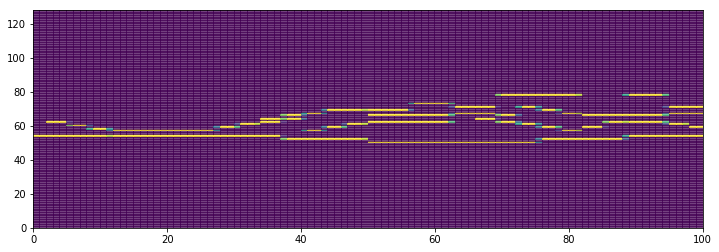

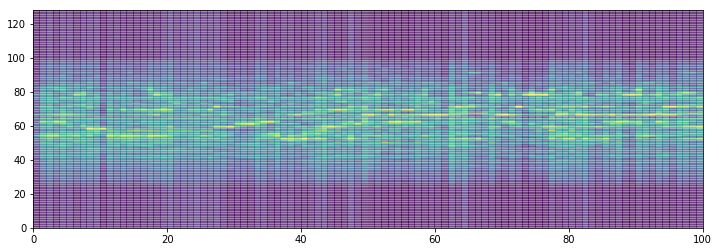

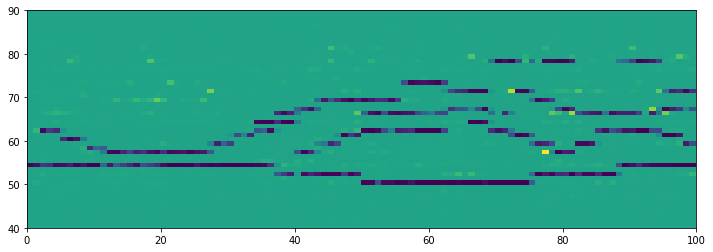

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 6.0944 - acc: 0.2646
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.26440, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.26.hdf5
40000/40000 [==============================] - 23s 564us/step - loss: 6.0946 - acc: 0.2645 - val_loss: 5.9841 - val_acc: 0.2644

Epoch 2/5
39872/40000 [============================>.] - ETA: 0s - loss: 6.0177 - acc: 0.2700
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.26440 to 0.26500, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-02-0.27.hdf5
40000/40000 [==============================] - 11s 271us/step - loss: 6.0162 - acc: 0.2699 - val_loss: 5.9282 - val_acc: 0.2650

Epoch 3/5
39936/40000 [============================>.] - ETA: 0s - loss: 6.0854 - acc: 0.2710
Epoch 00003: saving model 

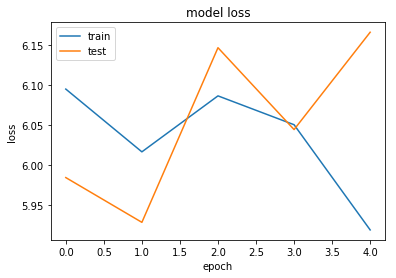

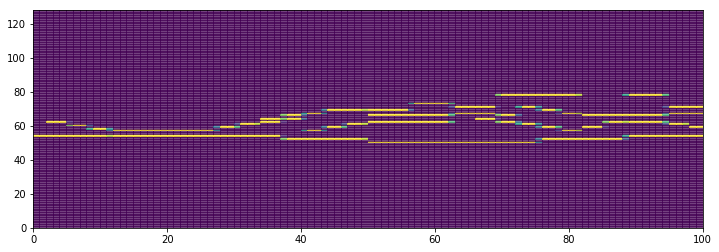

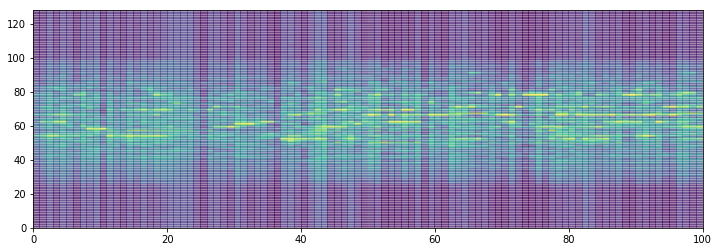

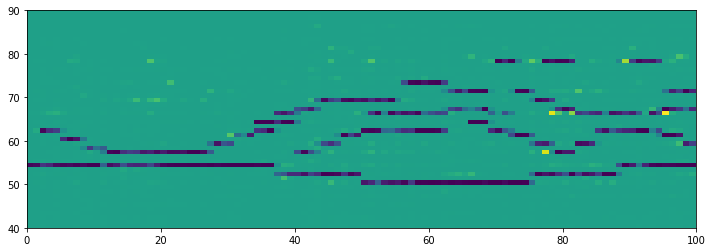

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39968/40000 [============================>.] - ETA: 0s - loss: 5.9936 - acc: 0.2740
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.26640, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.27.hdf5
40000/40000 [==============================] - 22s 547us/step - loss: 5.9931 - acc: 0.2740 - val_loss: 6.5897 - val_acc: 0.2664

Epoch 2/5
39904/40000 [============================>.] - ETA: 0s - loss: 5.9442 - acc: 0.2771
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.26640 to 0.27660, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-02-0.28.hdf5
40000/40000 [==============================] - 11s 269us/step - loss: 5.9448 - acc: 0.2771 - val_loss: 6.0915 - val_acc: 0.2766

Epoch 3/5
39968/40000 [============================>.] - ETA: 0s - loss: 5.8604 - acc: 0.2810
Epoch 00003: saving model 

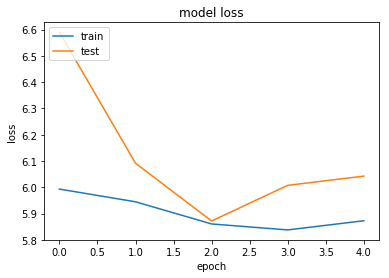

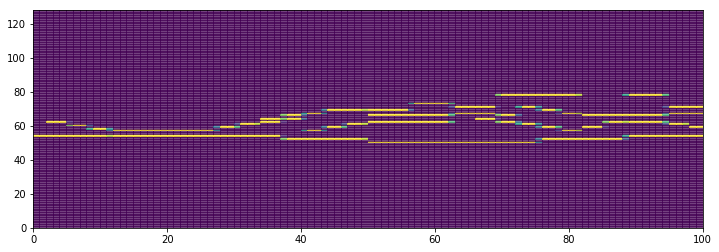

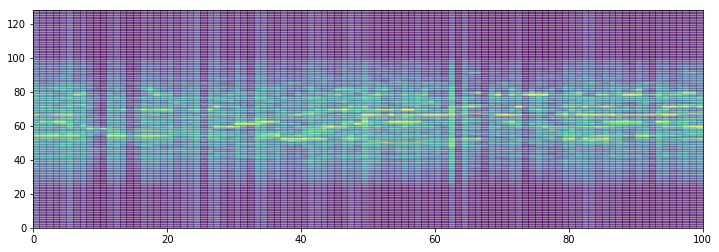

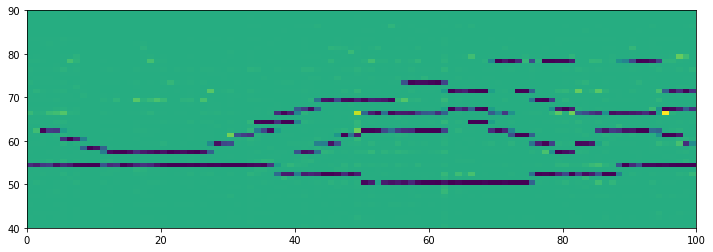

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39840/40000 [============================>.] - ETA: 0s - loss: 5.9083 - acc: 0.2809
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.28100, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.28.hdf5
40000/40000 [==============================] - 22s 547us/step - loss: 5.9071 - acc: 0.2810 - val_loss: 5.7760 - val_acc: 0.2810

Epoch 2/5
39904/40000 [============================>.] - ETA: 0s - loss: 5.8460 - acc: 0.2855
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.28100 to 0.29230, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-02-0.29.hdf5
40000/40000 [==============================] - 11s 274us/step - loss: 5.8465 - acc: 0.2854 - val_loss: 5.7644 - val_acc: 0.2923

Epoch 3/5
39904/40000 [============================>.] - ETA: 0s - loss: 5.9612 - acc: 0.2858
Epoch 00003: saving model 

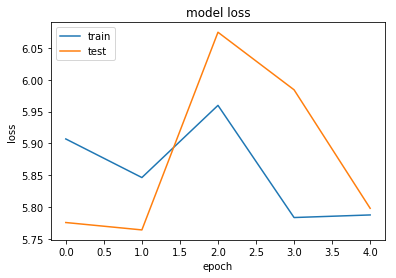

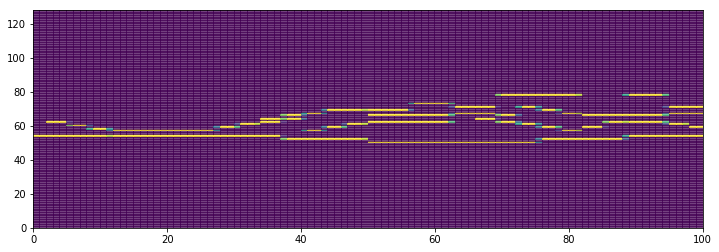

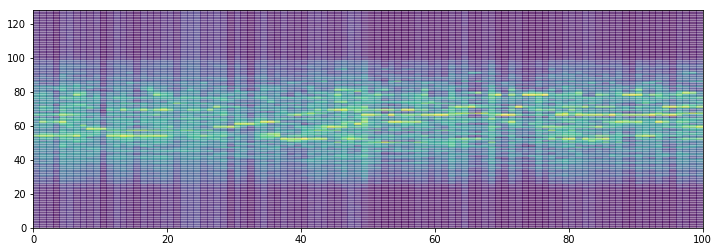

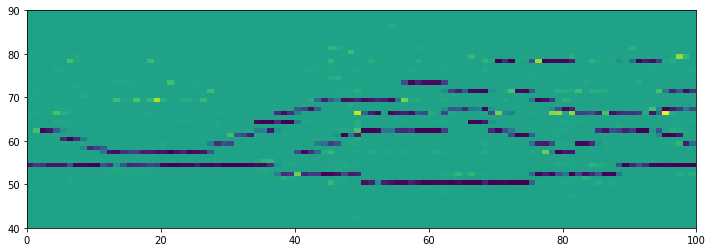

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39968/40000 [============================>.] - ETA: 0s - loss: 5.8351 - acc: 0.2870
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.29160, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.29.hdf5
40000/40000 [==============================] - 22s 550us/step - loss: 5.8352 - acc: 0.2870 - val_loss: 5.7038 - val_acc: 0.2916

Epoch 2/5
39904/40000 [============================>.] - ETA: 0s - loss: 5.8154 - acc: 0.2888
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.29160 to 0.29640, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-02-0.30.hdf5
40000/40000 [==============================] - 11s 273us/step - loss: 5.8145 - acc: 0.2885 - val_loss: 5.7138 - val_acc: 0.2964

Epoch 3/5
39840/40000 [============================>.] - ETA: 0s - loss: 5.7621 - acc: 0.2911
Epoch 00003: saving model 

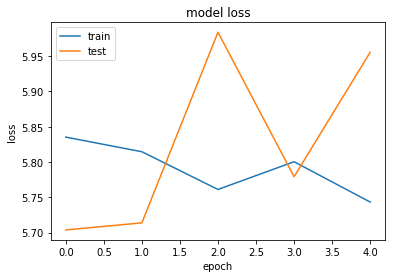

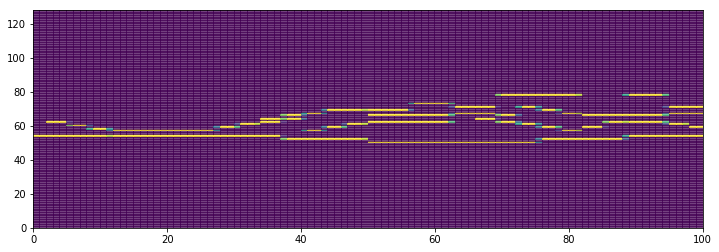

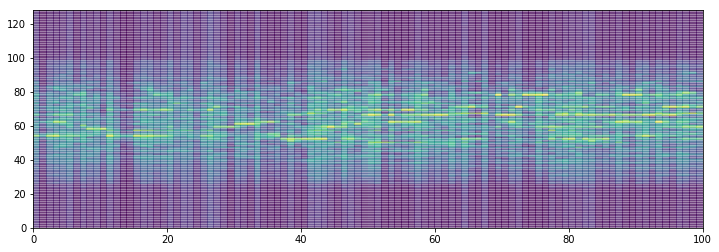

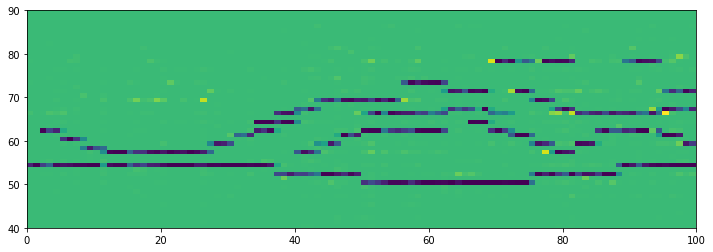

Train on 40000 samples, validate on 10000 samples

Epoch 1/5
39936/40000 [============================>.] - ETA: 0s - loss: 5.7956 - acc: 0.2958
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.30150, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.30.hdf5
40000/40000 [==============================] - 22s 561us/step - loss: 5.7960 - acc: 0.2957 - val_loss: 5.7431 - val_acc: 0.3015

Epoch 2/5
39840/40000 [============================>.] - ETA: 0s - loss: 5.7184 - acc: 0.2981
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.30150 to 0.30220, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-02-0.30.hdf5
40000/40000 [==============================] - 11s 273us/step - loss: 5.7188 - acc: 0.2981 - val_loss: 5.6509 - val_acc: 0.3022

Epoch 3/5
39776/40000 [============================>.] - ETA: 0s - loss: 5.7126 - acc: 0.2997
Epoch 00003: saving model 

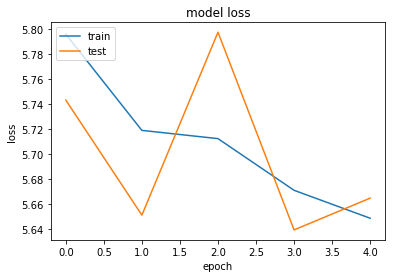

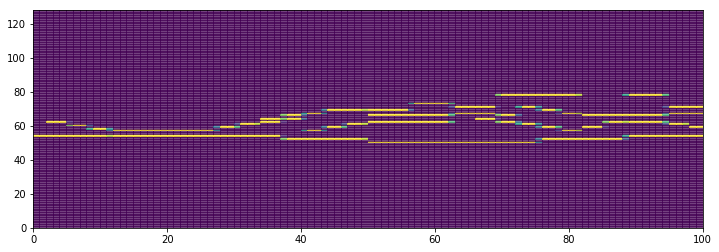

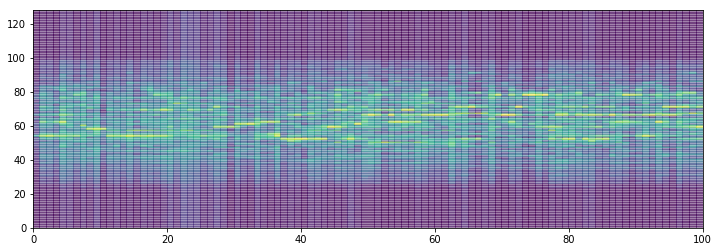

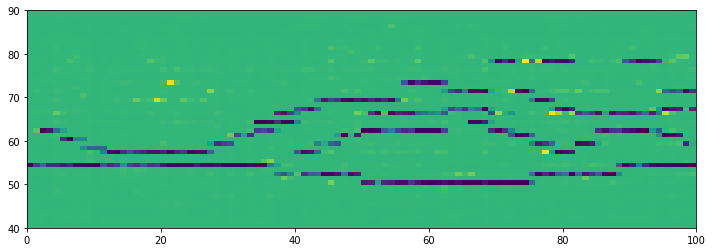

In [174]:
LOSS = abs_KL_div
opt_par = {'lr': 0.001, 'momentum': 0.75,'decay':0.000}
opt = keras.optimizers.sgd(**opt_par)
# for Xs,Ys in cDATA:

# opt = keras.optimizers.Adam(lr=0.01)
# LOSS = 'binary_crossentropy'
# LOSS = abs_KL_div

opt
Xs,Ys = cDATA
if 1:
    compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(5):
        agent,r = pretrain(agent,
                           bsize = 32,
#                            batchsize=-1,
                            batchsize = 50000,
#                             batchsize = 100000,
                           nepc = 5)
        compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
        plt.show()

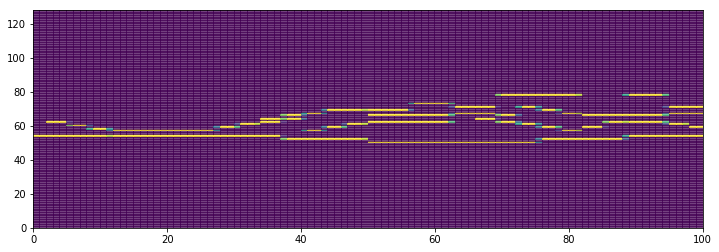

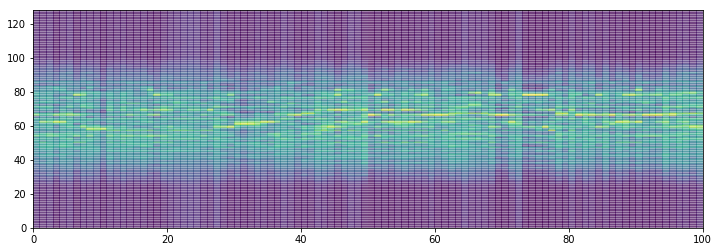

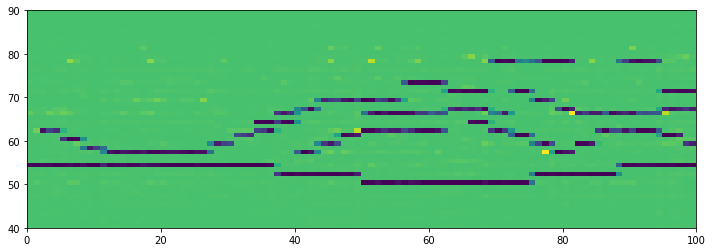

Train on 390093 samples, validate on 97524 samples

Epoch 1/2
389632/390093 [============================>.] - ETA: 0s - loss: 6.4940 - acc: 0.1906
Epoch 00001: saving model to Models/tst-best_only.hdf5
Epoch 00001: val_acc improved from -inf to 0.19279, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-01-0.19.hdf5
390093/390093 [==============================] - 58s 148us/step - loss: 6.4938 - acc: 0.1906 - val_loss: 6.4842 - val_acc: 0.1928

Epoch 2/2
389632/390093 [============================>.] - ETA: 0s - loss: 6.4682 - acc: 0.1942
Epoch 00002: saving model to Models/tst-best_only.hdf5
Epoch 00002: val_acc improved from 0.19279 to 0.19465, saving model to Models/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-02-0.19.hdf5
390093/390093 [==============================] - 46s 118us/step - loss: 6.4681 - acc: 0.1942 - val_loss: 6.4684 - val_acc: 0.1946


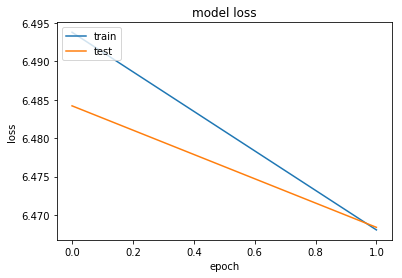

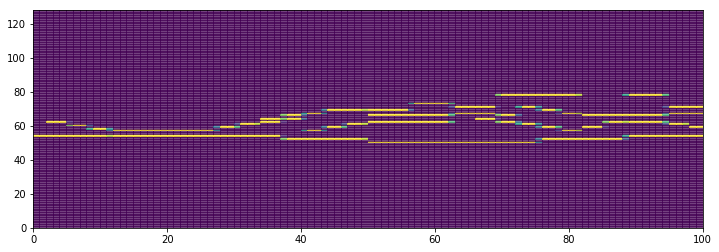

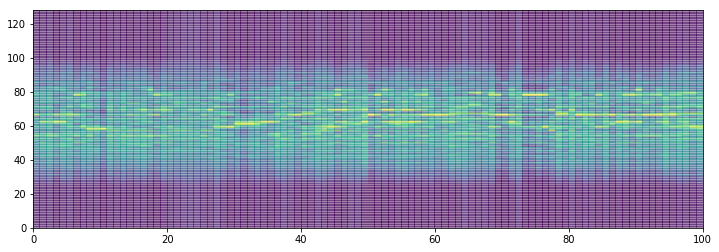

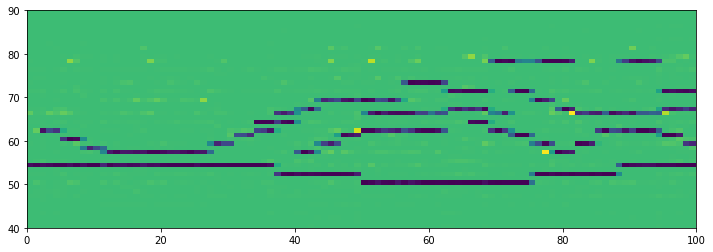

In [ ]:
opt_par = {'lr': 0.001, 'momentum': 0.75,'decay':0.000}
# for Xs,Ys in cDATA:
Xs,Ys = cDATA
if 1:
    compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
#     compare(log = 1, mode = 'test',chroma = 0)
    plt.show()

    for i in range(5):
        agent,r = pretrain(agent,
                           batchsize=-1,
#                             batchsize = 50000,
#                             batchsize = 100000,
                           nepc = 2)
        compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)
    #     compare(log = 1, mode = 'test',chroma = 0)
        plt.show()

sample/MIDI/jsbach/jsbwv533P-2S60


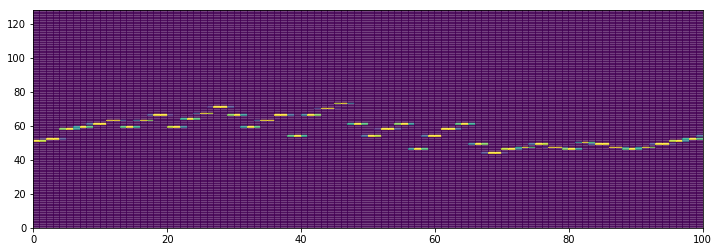

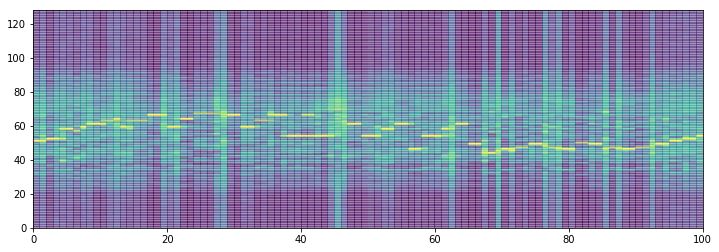

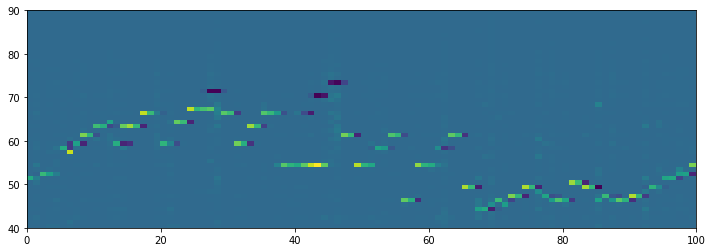

In [7]:
print data[0]['name']
compare(log = 1, mode = 'test',chroma = 0,overlap = 0, best_agent=agent)

In [ ]:
agent = _

In [10]:
def to_chunk(self,new_rate):
    ratio = self.bitrate/new_rate
    idx = np.arange(0, len(self.ts) ,ratio).astype(int)
    print len(idx)
    return np.array(np.split(self.xs, idx[1:])[:-1])

def transcribe(signal, agent,norm = 1, chroma = 1, log = 1):
    if isinstance( signal, util.piece):
        signal.downsample(16000)
        signal = signal.to_chunk(20)
#     plt.figure()

#     assert not (pXs[0] - Xs[0]).any()
#     pXs = Xs[:500]
#     pYs_exp = Ys[:500]
    pYs_act = agent.model.predict_on_batch(signal) 
    pYs_act += 1E-5
#     compare(log = 1)
    if chroma:
#        pYs_exp = mroll2chroma(pYs_exp)
        pYs_act = mroll2chroma(pYs_act,norm = 1)        
    Z1 = pYs_act.T
    if log:
        plt.pcolormesh(Z1,
                       alpha = 1.0,
                  norm=matplotlib.colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
                  )
    else:
        plt.pcolormesh(Z1)
    fs = np.arange(pYs_act.shape[-1])[None,:]
    pYs_act = (pYs_act)*fs
    ipd.display(ipd.Audio(midi_roll_play(pYs_act),rate = 16000))
    return pYs_act
import librosa
import librosa.display
def cqt(p):
    sr = p.bitrate
    y  = p.xs
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr, 
#                                            window = 50,
#                                           hop_length = 1
                                          )
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.show()
    return chroma_cq.T
def stft(p):
    sr = p.bitrate
    y  = p.xs
    chroma_cq = librosa.feature.chroma_stft(y=y, sr=sr,
                                           n_chroma=12, n_fft=800,
                                           hop_length=800)
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.show()
    return chroma_cq.T
# cqt(p)
# stft(p)
# compare(log = 0)

In [ ]:
# 'C','C#'
import librosa


In [47]:
agent.load('Models/archive/sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-05-0.25.hdf5')

In [39]:
!ls Models/* -t1 | head -n1 |xargs cp -t Models/archive
!ls Models/archive -lt

ls: write error: Broken pipe
total 12004
-rw-r--r-- 1 shouldsee shouldsee 5951232 Dec 14 21:33 sgd_t25_lr_0Dot001-momentum_0Dot75-decay_0Dot0-05-0.25.hdf5
-rw-rw-r-- 1 shouldsee shouldsee 3780040 Dec 12 19:46 sgd_t22_lr_0Dot01-momentum_0Dot75-decay_0Dot0-05-0.36.hdf5
-rw-rw-r-- 1 shouldsee shouldsee 1277432 Dec 12 02:34 sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-01-0.24.hdf5
-rw-rw-r-- 1 shouldsee shouldsee 1277360 Dec 12 00:43 sgd_t16_lr_0Dot01-momentum_0Dot75-decay_0Dot0-02-0.41.hdf5


0.965485
360


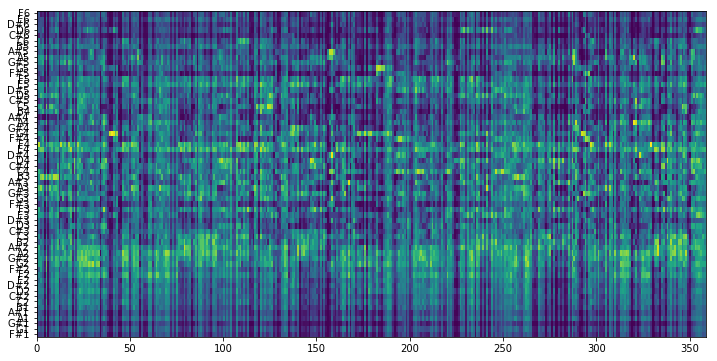

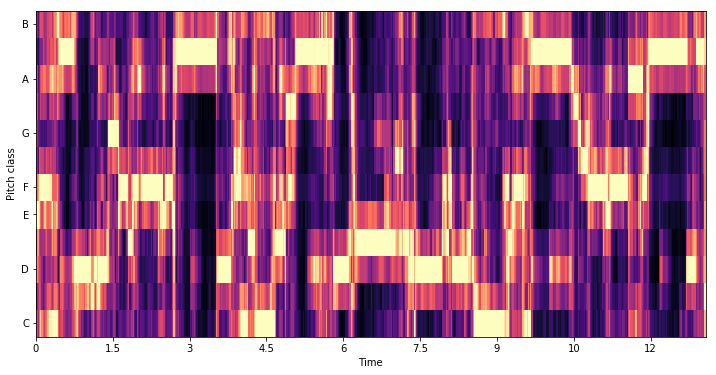

array([[ 0.58316661,  0.19244404,  0.77681898, ...,  0.318474  ,
         0.37025106,  0.56190772],
       [ 0.60667965,  0.45430481,  0.769335  , ...,  0.53281167,
         0.25163853,  0.41183564],
       [ 0.46323365,  0.5035387 ,  0.67254572, ...,  0.26622299,
         0.16502416,  0.28413755],
       ..., 
       [ 0.47991353,  0.42403571,  0.47152519, ...,  0.74114858,
         1.        ,  0.55014413],
       [ 0.45040986,  0.51329702,  0.70094358, ...,  0.91093867,
         1.        ,  0.51688153],
       [ 0.86228193,  1.        ,  0.83649078, ...,  0.63214114,
         0.910572  ,  0.80345365]])

In [175]:
import util#
best_agent = agent
# wavfile = 'sample/waltz_for_toutzy.wav'
wavfile = 'sample/waltz_for_toutzy_50.wav'
# wavfile = 'sample/Tamacun.wav'
# wavfile = 'sample/MIDI/composer-bach-edition-bg-genre-cant-work-0002-format-midi1-multi-zip-number-01.wav'
p = util.piece(wavfile)
print p.x0.max()
if p.x0.dtype=='int16':
    p.x0 = p.x0.astype('float32')
    p.x0 = p.x0/2**15
p.xs = p.x0
# p.xs = p.xs.astype('float32')
p.downsample(16000)
# p.bitrate = 18000
p.trimto(18,36)
# p.trimto(60,80)
# p.trimto(100,140)
# print len(p.xs)
chunks = to_chunk(p,20)[:]
chunks = np.array(chunks)
# chunks = util_midi.norm_by_rmsq(chunks,norm = 1)

eps = 1E-8
# chunks_SD = chunks.std(axis = 1,keepdims= 1) + eps
# chunks_M = chunks.mean(axis = 1,keepdims= 1) 
# # NZidx = np.squeeze( (chunks_SD)/chunks_M > 8)
# # chunks = chunks[NZidx,:]; mroll=mroll[NZidx,:]            
# # chunks = (chunks - chunks_M[NZidx,:])/chunks_SD[NZidx,:]
# chunks = (chunks - chunks_M)/chunks_SD
# chunks.shape
# len(p.x0)
# print len(chunks)
plt.figure(figsize = [12,6])
mroll = transcribe(chunks,best_agent,chroma = 0,)
ytk = librosa.midi_to_note(range(0,128))
plt.yticks(np.arange(0,128) +.5,librosa.midi_to_note(range(0,128)))
plt.ylim(30,90)

ipd.display(ipd.Audio(p.xs,rate=16000))
plt.figure(figsize = [12,6])
# print p.xs.dtype
cqt(p)


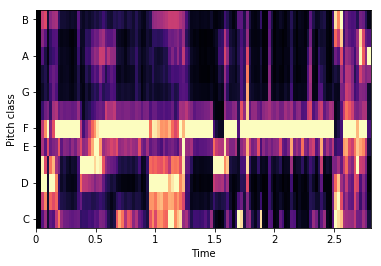

In [59]:
ipd.Audio(midi_roll_play(stft(p)),rate=16000)

In [149]:
%%bash
cd sample
wget "https://www.audioblocks.com/join/register?pre_email_click=details"
# !pip install librosa --user 


--2017-12-09 20:48:43--  https://www.audioblocks.com/join/register?pre_email_click=details
Resolving www.audioblocks.com (www.audioblocks.com)... 52.203.100.91, 52.203.214.179
Connecting to www.audioblocks.com (www.audioblocks.com)|52.203.100.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘register?pre_email_click=details.1’

     0K .......... .......... .......... .......... ..........  260K
    50K ....                                                    160M=0.2s

2017-12-09 20:48:44 (282 KB/s) - ‘register?pre_email_click=details.1’ saved [55613]



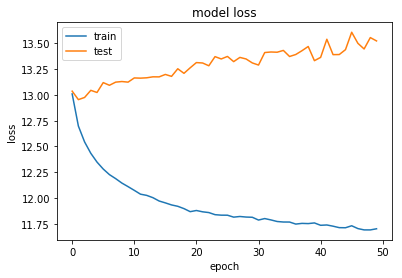

In [80]:
plot_model_loss(r)
# %matplotlib inline
# plt.plot(r.history['val_acc'])